:::{canonical-tutorial} how-to/knn-transformers
:::

# Using other kNN libraries in Scanpy

Since Scanpy was released, there has been quite some development in the space of approximate nearest neighbor detection.

In our example, we’re going to use [Annoy](https://github.com/spotify/annoy):

In [1]:
%pip install -qU "pip"
%pip install -q "scanpy" "sklearn-ann[annoy]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scanpy as sc
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # noqa: F401

sc.logging.print_header()

scanpy==1.10.0rc2.dev0+g48b495d9.d20240222 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


Our nearest neighbors implementation uses the PCA embedding by default, so let’s pre-compute that:

In [3]:
adata_default = sc.datasets.paul15()
sc.pp.pca(adata_default)
adata_annoy, adata_pynnd = adata_default.copy(), adata_default.copy()

The best way to use a third-party approximate nearest neighbors implementation is to use [`sklearn-ann`](https://github.com/scikit-learn-contrib/sklearn-ann). It provides *kNN Transformer classes* wrapping several popular approximate nearest neighbor libraries.

Explicitly setting the `transformer` parameter allows customizing how this function behaves.

By default, for small datasets, Scanpy just calculates all distances.
Setting the transformer parameter to `"pynndescent"` makes Scanpy always use its default for large datasets. 

In [4]:
%timeit sc.pp.neighbors(adata_default, n_neighbors=15)
%timeit sc.pp.neighbors(adata_pynnd, transformer="pynndescent", n_neighbors=15)
%timeit sc.pp.neighbors(adata_annoy, transformer=AnnoyTransformer(15))

29.3 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
683 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.1 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Looks like Annoy is quite a bit faster than PyNNDescent (but of course not as fast as Scanpy’s brute-force shortcut on a small dataset like this).

Let’s see if Leidenalg and UMAP get reasonable results when using each of the kNN graphs.

In [5]:
for adata in [adata_default, adata_annoy, adata_pynnd]:
    sc.tl.leiden(adata, flavor="igraph")
    sc.tl.umap(adata)

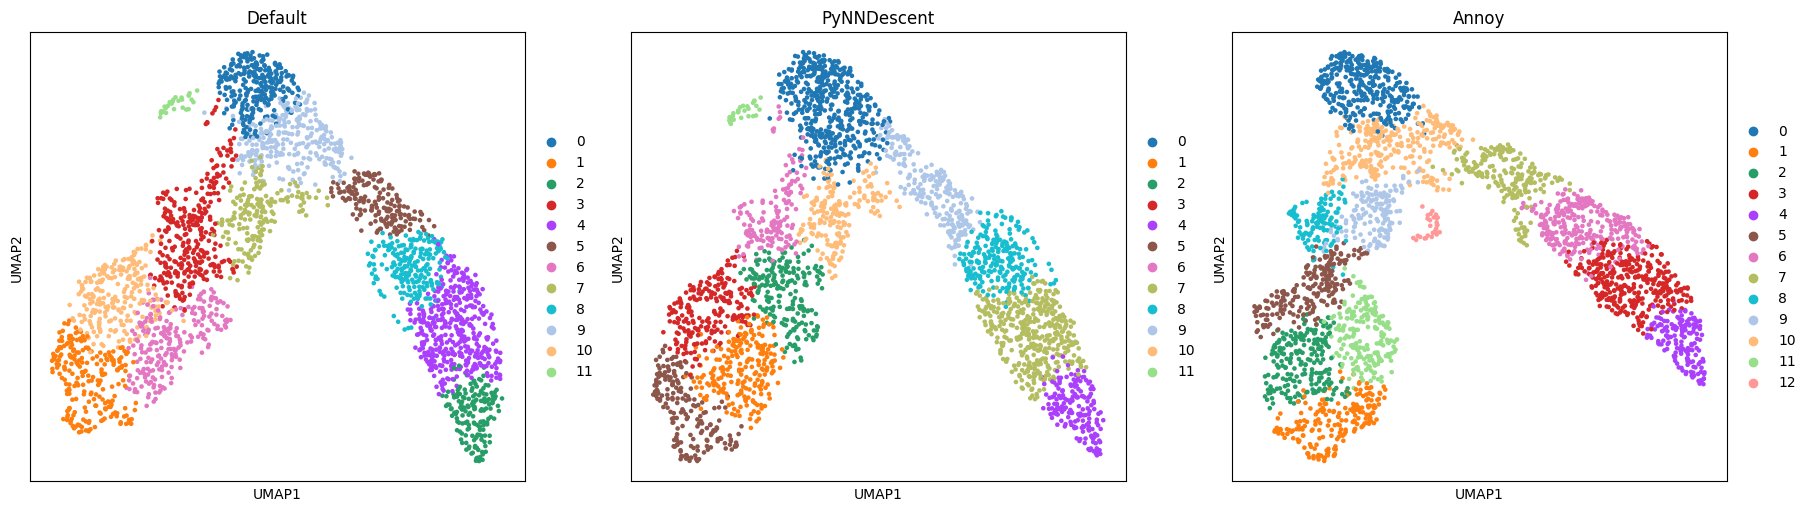

In [7]:
import matplotlib.pyplot as plt

with plt.ioff():
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), layout="constrained")
sc.pl.umap(adata_default, color="leiden", ax=axs[0], show=False, title="Default")
sc.pl.umap(adata_pynnd, color="leiden", ax=axs[1], show=False, title="PyNNDescent")
sc.pl.umap(adata_annoy, color="leiden", ax=axs[2], show=False, title="Annoy")
fig

The results look sensible enough.
Both embedding and community detection show some differences but are qualitatively the same:

The more narrow branch is divided into clusters length-wise, the wider one also horizontally,
and the small subpopulation is detected by both community detection and embedding.

This indicates that the underlying graph is similar enough to capture these features of the dataset.